In [1]:
import os
import sys
import time
import warnings
from random import shuffle

import numpy as np
import pandas as pd
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from tensorflow.python.lib.io import file_io
import numpy as np
import keras
from keras import backend as K
from keras.models import Sequential
from scipy.stats import kurtosis, skew
warnings.filterwarnings("ignore")

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from keras.layers import Conv2DTranspose, Dropout, Activation, BatchNormalization, UpSampling2D, Concatenate
from keras.layers import Input, Conv1D, MaxPooling1D, concatenate, TimeDistributed, Flatten, LSTM, Dense, GlobalAveragePooling1D
from keras.models import Model

In [3]:
# Window Length.
n = 100
STRIDE = 50

In [4]:
def getFeatures(data, fs):
    f1 = np.mean(data, axis=0)
    C = np.cov(data.T)
    f2 = np.concatenate((C[0, 0:3], C[1, 1:3], C[2, 2:3]))
    f3 = np.array([skew(data.iloc[:, 0]), skew(data.iloc[:, 1]), skew(data.iloc[:, 2])])
    f4 = np.array([kurtosis(data.iloc[:, 0]), kurtosis(data.iloc[:, 1]), kurtosis(data.iloc[:, 2])])
    f5 = np.zeros(3)
    f6 = np.zeros(3)
    for i in range(0,3):
        g = abs(np.fft.fft(data.iloc[:,i]))
        g = g[0:round(len(g)/2)]
        g[0] = 0
        max_i = np.argmax(g)
        f5[i] = g[max_i]
        f6[i] = fs * max_i
    return np.concatenate((f1, f2, f3, f4, f5, f6))

In [5]:
def generate_features(df, stride=STRIDE):
    df_out = pd.DataFrame(columns=[i for i in range(0, 42)])
    fs = 1 / n
    i = 0
    for i in range(0, df.shape[0] - n, stride):
        features_accel = getFeatures(df.iloc[i:i+n, 0:3], fs)
        features_gyro = getFeatures(df.iloc[i:i+n, 3:6], fs)
        features = np.concatenate((features_accel, features_gyro))
        df_out.loc[i] = features
        i += 1
    return df_out

In [6]:
# Choose via MODE ## TBD ##
def get_detection_window(df, stride=STRIDE):
    df_out = pd.DataFrame(columns=[0])
    i = 0
    for i in range(0, df.shape[0] - n, stride):
        df_slice = df.iloc[i:i+n,:]
        df_out.loc[i] = df_slice.mode().iloc[0,0]
#         df_out.loc[i] = df.iloc[i+n-1]
        i += 1
    return df_out

In [7]:
def extrapolate_predictions(predictions, size):
    extrapolated = np.fromiter((val for val in predictions for _ in range(0, STRIDE)), float)
    return extrapolated[0:size]

In [8]:
# Initializing dataframes for training and validation.
x_train = pd.DataFrame(columns=[i for i in range(0, 12)])
y_train = pd.DataFrame(columns=[0])
x_val = pd.DataFrame(columns=[i for i in range(0, 12)])
y_val = pd.DataFrame(columns=[0])

train_sessions = ['Session01', 'Session02', 'Session03', 'Session05', 'Session06', 'Session07', 'Session12', 'Session13', 'Session15']

count = 0
count_res = 0
for session in train_sessions:
    print('Processing training {}'.format(session))
    df_data_arm = pd.read_csv('TrainingDataB/{}/armIMU.txt'.format(session),  delim_whitespace=True, header=None)
    arm_features = generate_features(df_data_arm)
    df_data_wrist = pd.read_csv('TrainingDataB/{}/wristIMU.txt'.format(session), delim_whitespace=True, header=None)
    wrist_features = generate_features(df_data_wrist)
    count += df_data_arm.shape[0]
    features = pd.concat([arm_features, wrist_features], axis=1, sort=False, ignore_index=True)
    count_res += features.shape[0]
    df_data_detection = pd.read_csv('TrainingDataB/{}/detection.txt'.format(session), header=None)
    x_train = x_train.append(other=features, ignore_index=True)
    y_train = y_train.append(other=get_detection_window(df_data_detection), ignore_index=True)
print(count)
print(count_res)
x_train.to_csv('x_train.txt', header=False, index=False, sep='\t')
y_train.to_csv('y_train.txt', header=False, index=False, sep='\t')
print('Saved training features!')
    
val_sessions = ['Session16']
for session in val_sessions:
    df_data_arm = pd.read_csv('TrainingDataB/{}/armIMU.txt'.format(session),  delim_whitespace=True, header=None)
    arm_features = generate_features(df_data_arm)
    df_data_wrist = pd.read_csv('TrainingDataB/{}/wristIMU.txt'.format(session), delim_whitespace=True, header=None)
    wrist_features = generate_features(df_data_wrist)
    count += df_data_arm.shape[0]
    features = pd.concat([arm_features, wrist_features], axis=1, sort=False, ignore_index=True)
    count_res += features.shape[0]
    df_data_detection = pd.read_csv('TrainingDataB/{}/detection.txt'.format(session), header=None)
    x_val = x_val.append(other=features, ignore_index=True)
    y_val = y_val.append(other=get_detection_window(df_data_detection), ignore_index=True)
    
x_val.to_csv('x_val.txt', header=False, index=False, sep='\t')
y_val.to_csv('y_val.txt', header=False, index=False, sep='\t')
print('Saved validation features!')

Processing training Session01
Processing training Session02
Processing training Session03
Processing training Session05
Processing training Session06
Processing training Session07
Processing training Session12
Processing training Session13
Processing training Session15
1278577
25558
Saved training features!
Saved validation features!


In [9]:
x_train_df = np.loadtxt('x_train.txt', delimiter='\t')
y_train_df = np.loadtxt('y_train.txt', delimiter='\t')
x_val_df = np.loadtxt('x_val.txt', delimiter='\t')
y_val_df = np.loadtxt('y_val.txt', delimiter='\t')

In [10]:
X_train_reshaped = np.reshape(x_train_df, (x_train_df.shape[0], 1, x_train_df.shape[1]))
X_val_reshaped = np.reshape(x_val_df, (x_val_df.shape[0], 1, x_val_df.shape[1]))

In [11]:
print(X_val_reshaped.shape)
print(y_val_df.shape)

print(X_train_reshaped.shape)
print(y_train_df.shape)

(1766, 1, 84)
(1766,)
(25558, 1, 84)
(25558,)


## Build model

In [12]:
data_dim = 84
timesteps = 1
batch_size = 100

In [13]:
model = Sequential()
model.add(Conv1D(nb_filter=20, filter_length=1, padding='same', input_shape=(1, 84)))
model.add(LSTM(50, batch_input_shape=(batch_size, timesteps, data_dim)))
model.add(Dense(1, activation='sigmoid'))
model.add(BatchNormalization())
model.add(Activation('sigmoid'))

In [15]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [16]:
# define the checkpoint
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

## Training

In [18]:
history = model.fit(X_train_reshaped, y_train_df, batch_size=100, epochs=10, validation_data=(X_val_reshaped, y_val_df), callbacks=callbacks_list)


Train on 25558 samples, validate on 1766 samples
Epoch 1/10
25558/25558 [==============================] - 1s 49us/step - loss: 0.3720 - acc: 0.8399 - val_loss: 0.4750 - val_acc: 0.8001

Epoch 00001: loss improved from 0.38905 to 0.37195, saving model to model.h5
Epoch 2/10
25558/25558 [==============================] - 1s 50us/step - loss: 0.3584 - acc: 0.8438 - val_loss: 0.4990 - val_acc: 0.7673

Epoch 00002: loss improved from 0.37195 to 0.35837, saving model to model.h5
Epoch 3/10
25558/25558 [==============================] - 1s 49us/step - loss: 0.3551 - acc: 0.8435 - val_loss: 0.5000 - val_acc: 0.7627

Epoch 00003: loss improved from 0.35837 to 0.35506, saving model to model.h5
Epoch 4/10
25558/25558 [==============================] - 1s 54us/step - loss: 0.3550 - acc: 0.8443 - val_loss: 0.4429 - val_acc: 0.8171

Epoch 00004: loss improved from 0.35506 to 0.35498, saving model to model.h5
Epoch 5/10
25558/25558 [==============================] - 1s 51us/step - loss: 0.3563 - acc

In [19]:
score = model.evaluate(X_val_reshaped, y_val_df, batch_size=1)
print(list(zip(model.metrics_names,score)))

1766/1766 [==============================] - 2s 1ms/step
[('loss', 0.481455422177413), ('acc', 0.7599093997734995)]


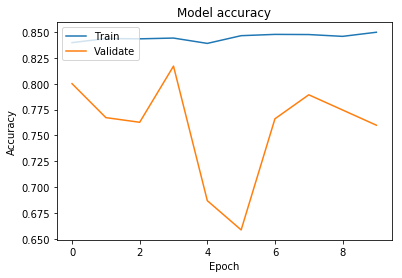

In [22]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validate'], loc='upper left')
# plt.show()
plt.savefig('acc.png')

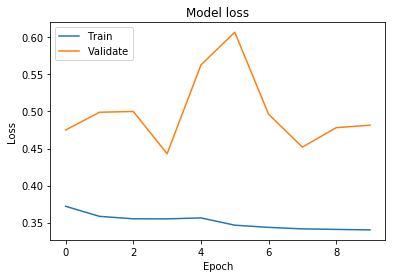

In [23]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validate'], loc='upper left')
# plt.show()
plt.savefig('loss.png')

In [24]:
def read_test_data(session):
    df_data_arm = pd.read_csv('TestData2/{}/armIMU.txt'.format(session), delim_whitespace=True, header=None)
    size = df_data_arm.shape[0]
    arm_features = generate_features(df_data_arm)
    df_data_wrist = pd.read_csv('TestData2/{}/wristIMU.txt'.format(session), delim_whitespace=True, header=None)
    wrist_features = generate_features(df_data_wrist)
    return size, pd.concat([arm_features, wrist_features], axis=1, sort=False, ignore_index=True)

In [26]:
# Prediction
from keras.models import load_model
test_sessions = ['Session08', 'Session09', 'Session11', 'Session17']

model_filename = 'model.h5'
print("Load this model: {}".format(model_filename))
loaded_model = load_model(model_filename)
for session in test_sessions:
    print("Predicting this session: {}".format(session))
    size, x_test = read_test_data(session)
    x_test.to_csv('{}_x_test.txt'.format(session), header=False, index=False, sep='\t')
    x_test_df = np.loadtxt('{}_x_test.txt'.format(session), delimiter='\t')
    X_test_reshaped = np.reshape(x_test_df, (x_test_df.shape[0], 1, x_test_df.shape[1]))
    print("Debug 1")
    predictions = loaded_model.predict_classes(X_test_reshaped, verbose=1)
    print("Debug 2")
    predictions = extrapolate_predictions(predictions, size)
    print("Debug 3")
    directory = 'prediction3b/{}'.format(session)
    if not os.path.exists(directory):
        os.makedirs(directory)
    filename = os.path.join(directory, 'prediction.txt')
    np.savetxt(filename, predictions, delimiter="\n")
    print("Finished")
    

Load this model: model.h5
Predicting this session: Session08
Debug 1
2793/2793 [==============================] - 0s 151us/step
Debug 2
Debug 3
Finished
Predicting this session: Session09
Debug 1
3755/3755 [==============================] - 0s 35us/step
Debug 2
Debug 3
Finished
Predicting this session: Session11
Debug 1
1610/1610 [==============================] - 0s 47us/step
Debug 2
Debug 3
Finished
Predicting this session: Session17
Debug 1
3356/3356 [==============================] - 0s 37us/step
Debug 2
Debug 3
Finished


In [ ]:
print("Predicting this session: {}".format(session))
size, x_test = read_test_data(session)
x_test.to_csv('{}_x_test.txt'.format(session), header=False, index=False, sep='\t')
x_test_df = np.loadtxt('{}_x_test.txt'.format(session), delimiter='\t')
X_test_reshaped = np.reshape(x_test_df, (x_test_df.shape[0], 1, x_test_df.shape[1]))
print("Debug 1")
predictions = loaded_model.predict_classes(X_test_reshaped, verbose=1)
print("Debug 2")
predictions = extrapolate_predictions(predictions, size)
print("Debug 3")
directory = 'prediction3b/{}'.format(session)
if not os.path.exists(directory):
    os.makedirs(directory)
filename = os.path.join(directory, 'prediction.txt')
np.savetxt(filename, predictions, delimiter="\n")
print("Finished")

In [45]:
df_data_arm = pd.read_csv('TrainingDataB/Session16/armIMU.txt'.format(session), delim_whitespace=True, header=None)
size = df_data_arm.shape[0]
arm_features = generate_features(df_data_arm)
df_data_wrist = pd.read_csv('TrainingDataB/Session16/wristIMU.txt'.format(session), delim_whitespace=True, header=None)
wrist_features = generate_features(df_data_wrist)
x_test = pd.concat([arm_features, wrist_features], axis=1, sort=False, ignore_index=True)
x_test_df = x_test.to_numpy()
X_test_reshaped = np.reshape(x_test_df, (x_test_df.shape[0], 1, x_test_df.shape[1]))
predictions = loaded_model.predict_classes(X_test_reshaped, verbose=1)
predictions = extrapolate_predictions(predictions, size)

y_actual = pd.read_csv('TrainingDataB/Session16/detection.txt'.format(session), header=None)
y_val = y_actual.to_numpy()


1766/1766 [==============================] - 0s 36us/step


(88300,)
(88354, 1)


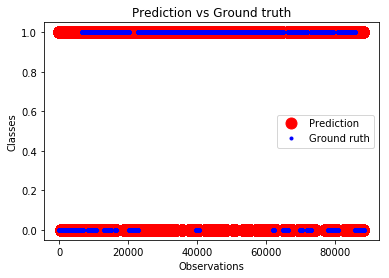

In [46]:
print(predictions.shape)
print(y_val.shape)
# summarize history for loss
plt.plot(predictions, 'r.', markersize=22)
plt.plot(y_val, 'b.')
plt.title('Prediction vs Ground truth')
plt.ylabel('Classes')
plt.xlabel('Observations')
plt.legend(['Prediction', 'Ground ruth'], loc='middle left')
# plt.show()
plt.savefig('pred_vs_gt.png')